<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Helper-function" data-toc-modified-id="Helper-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper function</a></span></li><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#Features-engineering" data-toc-modified-id="Features-engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Features engineering</a></span></li><li><span><a href="#Split-the-data" data-toc-modified-id="Split-the-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Split the data</a></span></li><li><span><a href="#MLPs" data-toc-modified-id="MLPs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>MLPs</a></span><ul class="toc-item"><li><span><a href="#No-inputs-scaling" data-toc-modified-id="No-inputs-scaling-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>No inputs scaling</a></span></li><li><span><a href="#With-inputs-scaling" data-toc-modified-id="With-inputs-scaling-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>With inputs scaling</a></span></li></ul></li><li><span><a href="#Comparing-the-performances" data-toc-modified-id="Comparing-the-performances-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Comparing the performances</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Comparising-learning-cuves" data-toc-modified-id="Comparising-learning-cuves-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Comparising learning cuves</a></span></li><li><span><a href="#Comparing-train-+-test-sets" data-toc-modified-id="Comparing-train-+-test-sets-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Comparing train + test sets</a></span></li><li><span><a href="#Comparing-test-set-only" data-toc-modified-id="Comparing-test-set-only-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Comparing test set only</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Scaling input for MLP applied to time series

<br></font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import callbacks

rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 16

# Helper function

In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Import dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- There are 9 days.
- Each day has 24 hrs. The observation has registered every hour.
- The total number of instances is: 9*24 = 216 points.

<br></font>
</div>

In [3]:
ads_col = 'Ads'
time_col = 'Time'
input_path = "../../DATASETS/ads.csv"
ads = pd.read_csv(input_path, index_col=time_col, parse_dates=[time_col])
print('dimension: ', ads.shape)
ads.head()

dimension:  (216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


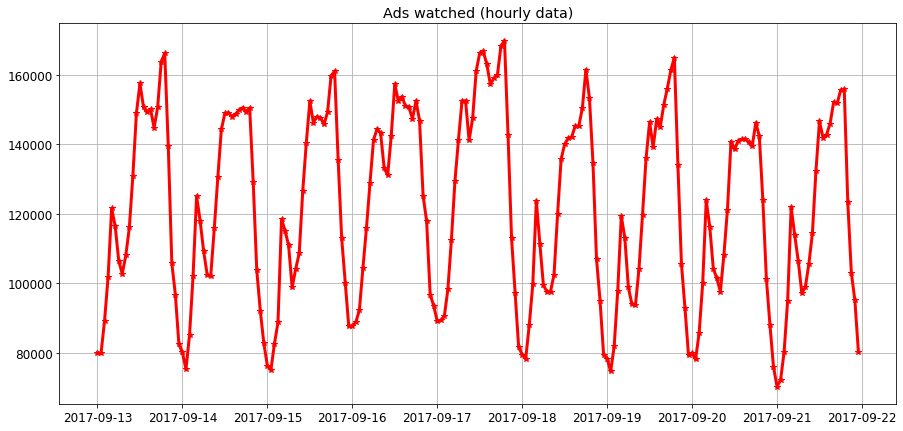

In [4]:
rcParams['font.size'] = 12
#register_matplotlib_converters()
plt.figure(figsize = (15, 7))
plt.plot(ads[ads_col], "r*-", lw = 3)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

# Features engineering

<div class="alert alert-block alert-info">
<font color=black><br>

- Generating lagged features and window statistics from them.
- We will also add date & time features such as hour of the day, day of the week and a boolean feature indicating whether this is a weekend.
- **Window statistics**: mean of the lagged features we've created.

<br></font>
</div>

In [5]:
label_col = 'y'
data = pd.DataFrame(ads[ads_col].copy())
data.columns = [label_col]

# Add the lag of the target variable from 6 steps back up to 24
# 24 means 25 hours thus one day
for i in range(6, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)
    
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
# 5 and 6 means Saturday and Sunday
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(np.int)

data = data.dropna()
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,80125,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0
2017-09-14 01:00:00,75335,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0
2017-09-14 02:00:00,85105,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0
2017-09-14 03:00:00,102080,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0
2017-09-14 04:00:00,125135,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,...,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0


In [6]:
data.shape

(192, 23)

In [7]:
dataAll = copy.deepcopy(data)

In [8]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()

dimension:  (192, 23)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend,rolling_mean
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,...,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0,0,3,0,124731.052632
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,...,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,1,3,0,129263.684211
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,...,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,2,3,0,132402.368421
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,...,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,3,3,0,133274.473684
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,...,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,4,3,0,133003.421053


In [9]:
pd.DataFrame(y)

,0
0,80125
1,75335
2,85105
3,102080
4,125135
...,...
187,155890
188,123395
189,103080
190,95155


# Split the data

In [10]:
def timeseries_train_test_split(X, y, test_size = 0.3):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y)

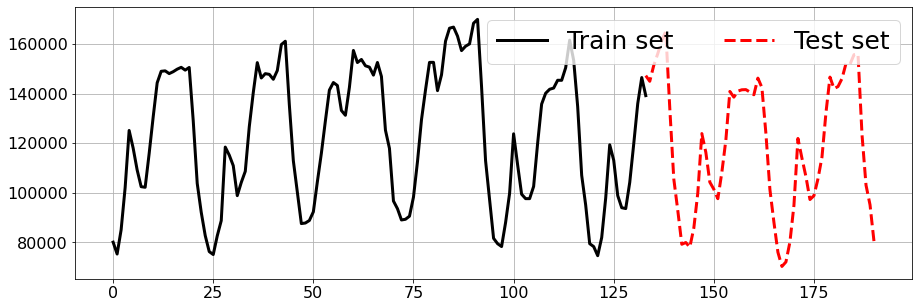

In [12]:
plt.figure(figsize=(15, 5))
rcParams['font.size'] = 16
x_train = range(y_train.size)

# Adding a shift
x_test = [i + max(x_train) for i in range(y_test.size)]

plt.plot(x_train, y_train, "k-", lw = 3, label = 'Train set')
plt.plot(x_test, y_test, "r--", lw = 3, label = 'Test set')

plt.legend(loc='best', ncol = 2, fontsize = 25)
plt.grid(True)

# MLPs

<div class="alert alert-block alert-info">
<font color=black><br>

- ANNs are **sensitive** to the scaling of their inputs.
- So we are going to normalised the input.
- This is different from tree-based methods such as a gradietn boosting and random forest. For this method scaling is not necessary.

<br></font>
</div>

## No inputs scaling

In [13]:
early_stopping = callbacks.EarlyStopping(
    # Minimium amount of change to count as an improvement
    min_delta=0.001, 
    # How many epochs to wait before stopping
    patience = 100, 
    restore_best_weights = True,
)

In [14]:
modelMLP = Sequential()
lookBack = 24
modelMLP.add(Dense(30, activation = "relu"))
modelMLP.add(Dense(1))
modelMLP.compile(loss = "mean_squared_error", metrics = ["mae"], optimizer = "adam")
historyMLP = modelMLP.fit(X_train, y_train, 
                          validation_data = (X_test, y_test), 
                          epochs = 300, 
                          batch_size = 2, 
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/300
67/67 [==============================] - 18s 7ms/step - loss: 26545782648.4706 - mae: 137723.2491 - val_loss: 1742851840.0000 - val_mae: 36559.4922
Epoch 2/300
67/67 [==============================] - 0s 1ms/step - loss: 1490071403.2941 - mae: 32344.8172 - val_loss: 1045126784.0000 - val_mae: 25585.2285
Epoch 3/300
67/67 [==============================] - 0s 1ms/step - loss: 854526863.0588 - mae: 24450.8532 - val_loss: 743155904.0000 - val_mae: 21057.2168
Epoch 4/300
67/67 [==============================] - 0s 2ms/step - loss: 616677748.4706 - mae: 20327.5266 - val_loss: 591330176.0000 - val_mae: 17730.7285
Epoch 5/300
67/67 [==============================] - 0s 2ms/step - loss: 536658472.4706 - mae: 18862.8631 - val_loss: 451619264.0000 - val_mae: 15400.2129
Epoch 6/300
67/67 [==============================] - 0s 2ms/step - loss: 386629006.4706 - mae: 15730.0444 - val_loss: 362091840.0000 - val_mae: 14378.5996
Epoch 7/300
67/67 [==============================] - 0s 2ms/ste

67/67 [==============================] - 0s 1ms/step - loss: 216886441.5294 - mae: 11261.7610 - val_loss: 63059116.0000 - val_mae: 6513.5688
Epoch 55/300
67/67 [==============================] - 0s 1ms/step - loss: 154387301.5882 - mae: 9486.5449 - val_loss: 82061896.0000 - val_mae: 7189.3896
Epoch 56/300
67/67 [==============================] - 0s 1ms/step - loss: 149533561.2941 - mae: 9138.8559 - val_loss: 93881744.0000 - val_mae: 8129.6294
Epoch 57/300
67/67 [==============================] - 0s 1ms/step - loss: 142422735.0000 - mae: 8565.6921 - val_loss: 65232124.0000 - val_mae: 6471.6719
Epoch 58/300
67/67 [==============================] - 0s 1ms/step - loss: 166191366.3529 - mae: 9092.0884 - val_loss: 64814340.0000 - val_mae: 6526.9404
Epoch 59/300
67/67 [==============================] - 0s 1ms/step - loss: 165087454.0000 - mae: 9269.9009 - val_loss: 68372456.0000 - val_mae: 6651.5146
Epoch 60/300
67/67 [==============================] - 0s 1ms/step - loss: 186291605.4118 - mae

67/67 [==============================] - 0s 1ms/step - loss: 113040773.1765 - mae: 8091.9791 - val_loss: 59522760.0000 - val_mae: 6315.5942
Epoch 161/300
67/67 [==============================] - 0s 1ms/step - loss: 85422769.2316 - mae: 7028.3664 - val_loss: 59252924.0000 - val_mae: 6245.1206
Epoch 162/300
67/67 [==============================] - 0s 1ms/step - loss: 97919465.1471 - mae: 7220.0876 - val_loss: 79780176.0000 - val_mae: 7297.2568
Epoch 163/300
67/67 [==============================] - 0s 1ms/step - loss: 118549633.0588 - mae: 8682.7446 - val_loss: 79543624.0000 - val_mae: 7272.8384
Epoch 164/300
67/67 [==============================] - 0s 1ms/step - loss: 134929002.9412 - mae: 8577.2258 - val_loss: 84070216.0000 - val_mae: 7419.6665
Epoch 165/300
67/67 [==============================] - 0s 1ms/step - loss: 143866342.1176 - mae: 9537.0340 - val_loss: 67929880.0000 - val_mae: 6541.0366
Epoch 166/300
67/67 [==============================] - 0s 1ms/step - loss: 97028514.0000 - m

67/67 [==============================] - 0s 1ms/step - loss: 99278211.5588 - mae: 8063.6008 - val_loss: 61163304.0000 - val_mae: 6414.0151
Epoch 267/300
67/67 [==============================] - 0s 1ms/step - loss: 80601981.7059 - mae: 6844.7447 - val_loss: 56886896.0000 - val_mae: 6276.4604
Epoch 268/300
67/67 [==============================] - 0s 1ms/step - loss: 84996452.1176 - mae: 7012.2881 - val_loss: 62354072.0000 - val_mae: 6457.1758
Epoch 269/300
67/67 [==============================] - 0s 1ms/step - loss: 68251640.0588 - mae: 6620.9415 - val_loss: 101253624.0000 - val_mae: 8237.5557


**Learning curves**

## With inputs scaling

<div class="alert alert-block alert-info">
<font color=black><br>

- Pay attention to **data leakage**.
- We are scaling the data after we did the splitting.
- If you scale the data all together some features of the test set will be used into the training and this is **bad practice**.

<br></font>
</div>

In [17]:
scaler_Xtrain = MinMaxScaler(feature_range = (0, 1))
X_train_s = scaler_Xtrain.fit_transform(X_train)
scaler_ytrain = MinMaxScaler(feature_range = (0, 1))
y_train_s = scaler_ytrain.fit_transform(y_train.reshape(-1, 1))

scaler_Xtest = MinMaxScaler(feature_range = (0, 1))
X_test_s = scaler_Xtest.fit_transform(X_test)
scaler_ytest = MinMaxScaler(feature_range = (0, 1))
y_test_s = scaler_ytest.fit_transform(y_test.reshape(-1, 1))

In [18]:
# Reshape the numpy.array for keras
print(X_train.shape, y_train.shape)
print(X_train_s.shape, y_train_s.shape)

(134, 23) (134,)
(134, 23) (134, 1)


In [19]:
print(X_test.shape, y_test.shape)
print(X_test_s.shape, y_test_s.shape)

(58, 23) (58,)
(58, 23) (58, 1)


In [20]:
modelMLP_s = Sequential()
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(16, activation = "relu"))
modelMLP_s.add(Dense(1))
modelMLP_s.compile(loss = "mean_squared_error", metrics = ["mae"], optimizer = "adam")
historyMLP_s = modelMLP_s.fit(X_train_s, y_train_s, 
                          validation_data = (X_test_s, y_test_s), 
                          epochs = 300, 
                          batch_size = 1, 
                          verbose = 1,
                          callbacks = [early_stopping])

Epoch 1/300
134/134 [==============================] - 1s 3ms/step - loss: 0.2595 - mae: 0.3810 - val_loss: 0.0377 - val_mae: 0.1528
Epoch 2/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0214 - mae: 0.1191 - val_loss: 0.0299 - val_mae: 0.1430
Epoch 3/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0195 - mae: 0.1176 - val_loss: 0.0226 - val_mae: 0.1163
Epoch 4/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0195 - mae: 0.1123 - val_loss: 0.0178 - val_mae: 0.1065
Epoch 5/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0126 - mae: 0.0900 - val_loss: 0.0187 - val_mae: 0.1038
Epoch 6/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0192 - mae: 0.1117 - val_loss: 0.0141 - val_mae: 0.0906
Epoch 7/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0087 - mae: 0.0734 - val_loss: 0.0124 - val_mae: 0.0897
Epoch 8/300
134/134 [==============================] - 0s 1ms/step - 

134/134 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0376 - val_loss: 0.0054 - val_mae: 0.0588
Epoch 124/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0024 - mae: 0.0378 - val_loss: 0.0117 - val_mae: 0.0875
Epoch 125/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0349 - val_loss: 0.0080 - val_mae: 0.0736
Epoch 126/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0332 - val_loss: 0.0062 - val_mae: 0.0644
Epoch 127/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 0.0088 - val_mae: 0.0740
Epoch 128/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0019 - mae: 0.0357 - val_loss: 0.0065 - val_mae: 0.0636
Epoch 129/300
134/134 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0335 - val_loss: 0.0067 - val_mae: 0.0661
Epoch 130/300
134/134 [==============================] - 0s 1ms/step 

# Comparing the performances

In [30]:
# Estimate model performance
predictionTestMLP= modelMLP.predict(X_test)
predictionTrainMLP = modelMLP.predict(X_train)

In [31]:
errorTestMLP = mean_absolute_percentage_error(predictionTestMLP, y_test)
errorTrainMLP = mean_absolute_percentage_error(predictionTrainMLP, y_train)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestMLP))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainMLP))

Mean absolute percentage [TEST] error 26.75%
Mean absolute percentage [TRAIN] error 26.43%


In [32]:
# Estimate model performance
predictionTestMLP_s = modelMLP_s.predict(X_test_s)
predictionTrainMLP_s = modelMLP_s.predict(X_train_s)

In [33]:
errorTestMLP_s = mean_absolute_percentage_error(predictionTestMLP_s, y_test_s)
errorTrainMLP_s = mean_absolute_percentage_error(predictionTrainMLP_s, y_train_s)
print('Mean absolute percentage [TEST] error {0:.2f}%'.format(errorTestMLP_s))
print('Mean absolute percentage [TRAIN] error {0:.2f}%'.format(errorTrainMLP_s))

Mean absolute percentage [TEST] error 26.70%
Mean absolute percentage [TRAIN] error 11.39%


# Plotting

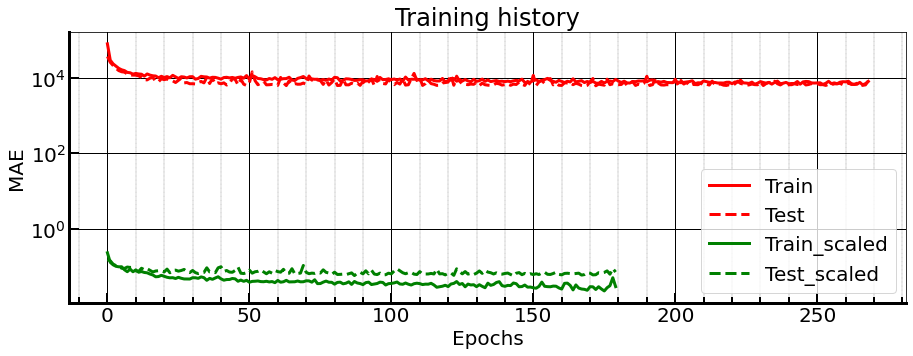

In [29]:
# Plotting options
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20

fig, ax = plt.subplots()

# No scaling
epochs = len(historyMLP.history[ "mae"]) 
x_axis = range(0, epochs)

ax.plot(x_axis, historyMLP.history[ "mae"], 'r-', lw = 3, label = 'Train') 
ax.plot(x_axis, historyMLP.history[ "val_mae"], 'r--', lw = 3, label = 'Test') 

# Scaling
epochs_s = len(historyMLP_s.history[ "mae"]) 
x_axis_s = range(0, epochs_s)
ax.plot(x_axis_s, historyMLP_s.history[ "mae"], 'g-', lw = 3, label = 'Train_scaled') 
ax.plot(x_axis_s, historyMLP_s.history[ "val_mae"], 'g--', lw = 3, label = 'Test_scaled') 

ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("MAE")
plt.title('Training history')
ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
plt.yscale('log')
ax.minorticks_on()
plt.show()

## Comparising learning cuves

## Comparing train + test sets

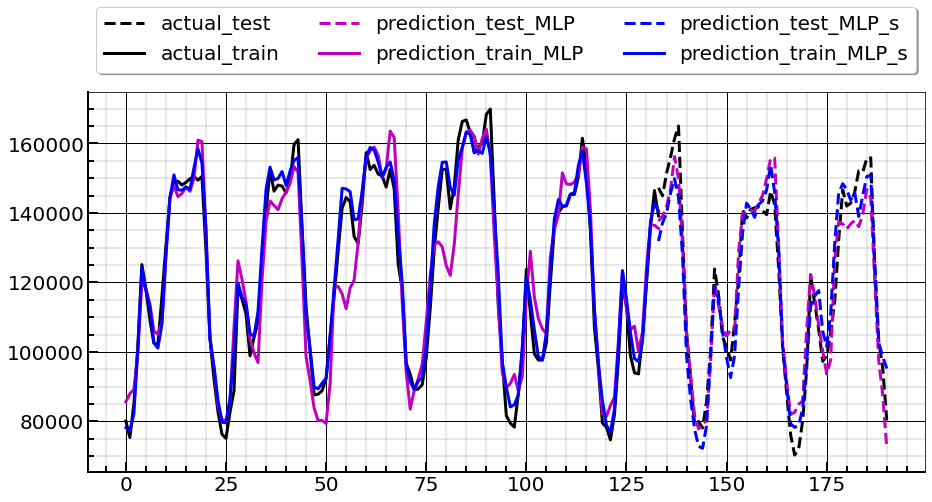

In [24]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

x_train = range(y_train.size)
x = [i + max(x_train) for i in range(y_test.size)]

# Train and test sets
plt.plot(x, y_test, "k--", lw = 3, label='actual_test')
plt.plot(x_train, y_train, "k-", lw = 3, label='actual_train')


# MLPs results
plt.plot(x, predictionTestMLP, "m--", lw = 3, label = 'prediction_test_MLP')
plt.plot(x_train, predictionTrainMLP, "m-", lw = 3, label = 'prediction_train_MLP')

# MLPs results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestMLP_s), "b--", lw = 3, label = 'prediction_test_MLP_s')
plt.plot(x_train, scaler_ytrain.inverse_transform(predictionTrainMLP_s), "b-", lw = 3, label = 'prediction_train_MLP_s')


ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol = 3, fancybox=True, shadow=True)

plt.grid(True)

## Comparing test set only

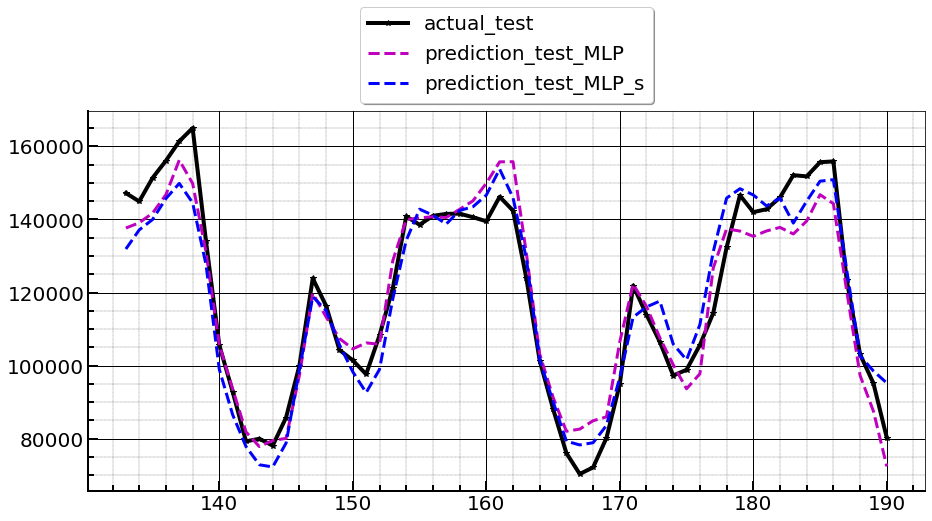

In [25]:
fig = plt.figure(figsize=(15, 7)) 
ax = fig.add_subplot(111) 

x_train = range(y_test.size)

# Train and test sets
plt.plot(x, y_test, "k*-", lw = 4, label='actual_test')


# MLPs results
plt.plot(x, predictionTestMLP, "m--", lw = 3, label = 'prediction_test_MLP')

# MLPs results
plt.plot(x, scaler_ytest.inverse_transform(predictionTestMLP_s), "b--", lw = 3, label = 'prediction_test_MLP_s')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.3),
          ncol = 1, fancybox=True, shadow=True)

plt.grid(True)

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-danger">
<font color=black>

- For this test cases we show how:
    - Scaling the input change the convergence history quite a lot.
    - The result in the test set do not seem to be so different.    

</font>
</div>

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-warning">
<font color=black>

- [Partially inspired by this notebook](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/time_series/3_supervised_time_series.ipynb)

</font>
</div>